In [2]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete
from ray.rllib.utils.spaces.repeated import Repeated
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy

In [3]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 6
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = 0

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        randomized = list(self.devices.keys())
        random.shuffle(randomized)
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: randomized[:bound],
            1: randomized[bound:bound*2],
            2: randomized[bound*2:bound*3],
            3: randomized[bound*3:]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def rl_update(self, new_allocation):
        self.data_allocation = new_allocation
        self.construct_dictionaries()
        return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation - 10],1)
            self.action_device.append(device[0])
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def greedy_algorithm(self):
        if self.space_flag == 0:
            print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation
            self.construct_dictionaries()
        else:
            print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = 0
            self.greedy_algorithm()

In [4]:
architecture = Architecture()
for i in range(5):
    architecture.heart_beat()
    architecture.generate(3)
    # architecture.generate(2)
    # architecture.generate(1)
    # architecture.generate(0)
    architecture.greedy_algorithm()
    print(architecture.data_allocation)
    print(1 - architecture.compute_normalized_latency())
    print(np.std(list(architecture.free_space().values())))
    print(architecture.free_space())
# architecture.generate(2)
# print(architecture.data_allocation)
# print(architecture.data_types)
# print(architecture.data_times)
# print(architecture.latencies)
# print(architecture.compute_total_latency())
# print(architecture.action_device)
# print(architecture.action_type)
# architecture.free_space()
# print(architecture.latencies)

It's ok
[3, 5, 3, 5, 3, 5]
1.0
0.3247595264191645
{0: 1.0, 1: 1.0, 2: 1.0, 3: 0.25, 4: 1.0, 5: 0.25, 6: 1.0, 7: 1.0}
It's ok
[5, 3, 5, 3, 3, 5, 3, 3, 5, 5, 5, 3]
1.0
0.649519052838329
{0: 1.0, 1: 1.0, 2: 1.0, 3: -0.5, 4: 1.0, 5: -0.5, 6: 1.0, 7: 1.0}
Problem
It's ok
[3, 1, 5, 0, 0, 3, 0, 1, 3, 0, 0, 0]
1.0
0.24576411454889013
{0: 0.94, 1: 0.98, 2: 1.0, 3: 0.25, 4: 1.0, 5: 0.75, 6: 1.0, 7: 1.0}
It's ok
[0, 5, 1, 3, 0, 3, 1, 5, 3, 1, 1, 1]
1.0
0.27331300737432895
{0: 0.98, 1: 0.95, 2: 1.0, 3: 0.25, 4: 1.0, 5: 0.5, 6: 1.0, 7: 1.0}
It's ok
[3, 1, 1, 3, 0, 5, 0, 5, 0, 5, 0, 0]
1.0
0.27331300737432895
{0: 0.95, 1: 0.98, 2: 1.0, 3: 0.5, 4: 1.0, 5: 0.25, 6: 1.0, 7: 1.0}


In [5]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]
architecture = Architecture()

for j in executions:
    architecture.heart_beat()
    for h in j:
        architecture.generate(h)
    print(1-architecture.compute_normalized_latency())
    print(np.std(list(architecture.free_space().values())))
    print(len(architecture.data_allocation))

0.5586206896551724
0.006962844246426928
24
0.4457274826789839
0.011327612281500489
40
0.4230235783633842
0.011327612281500489
40
0.4230235783633842
0.11958078775455531
46
0.4450867052023122
0.11958078775455531
46
0.4310494362532524
0.11958078775455531
46
0.42262317834836916
0.11958078775455531
46
0.42262317834836916
0.22783396322761015
52
0.41339770669885334
0.22783396322761015
52


In [6]:
class AcesArchitectureEnv(Env):
    def __init__(self, maximum_data):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.maximum_data = maximum_data

        self.weigths = self.architecture.weights
        self.allocation = self.architecture.data_allocation
        self.data_types = self.architecture.data_types
        self.free_space = list(self.architecture.free_space().values())
        self.last_calls_type = self.architecture.action_type
        self.last_calls_device = self.architecture.action_device

        self.observation_space = Dict({
            "weights": Box(low=0, high=1, shape=(4,), dtype=np.float32),
            "allocation": Box(low=-1, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32),
            # "allocation": Repeated(Discrete(self.num_devices),maximum_data),
            "data_type": Box(low=-1, high=3, shape=(maximum_data,), dtype=np.int32),
            # "data_type": Repeated(Discrete(4),maximum_data),
            "free_space": Box(low=-10, high=1, shape=(self.num_devices,), dtype=np.float32),
            "last_calls_type": Box(low=-1, high=13, shape=(10,), dtype=np.int32),
            # "last_calls_type": Repeated(Discrete(4,start=10),10),
            "last_calls_device": Box(low=-1, high=self.num_devices-1, shape=(10,), dtype=np.int32)
            # "last_calls_device": Repeated(Discrete(self.num_devices),10)
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32)

        self.allocation_length = len(self.allocation)

        self.reward = 0

    def get_obs(self):

        return {
            "weights": np.array(self.weigths),
            "allocation": np.array(self.allocation),
            "data_type": np.array(self.data_types),
            "free_space": np.array(self.free_space),
            "last_calls_type": np.array(self.last_calls_type),
            "last_calls_device": np.array(self.last_calls_device)
        }

    def step(self,action):
        self.architecture.data_allocation = list(action[:self.allocation_length])
        self.allocation[:self.allocation_length] = list(action[:self.allocation_length])
        self.architecture.construct_dictionaries()
        normalized_latency = self.architecture.compute_normalized_latency()
        self.free_space = list(self.architecture.free_space().values())

        flag = False
        for i in self.free_space:
            if i <= self.architecture.min_free_space:
                flag = True
                break

        if flag:
            self.reward = -10
        else:
            w1 = 1
            w2 = 1
            std = np.std(self.free_space)
            self.reward = w1*(1 - normalized_latency) + w2*(1-std)

        done = True
        info = {}

        return self.get_obs(), self.reward, done, info

    def reset(self):
        if self.reward < 0:
            return self.get_obs()
        else:
            self.architecture.heart_beat()
            for execution in self.executions[self.execution_index]:
                self.architecture.generate(execution)
            self.allocation = self.architecture.data_allocation.copy()
            self.data_types = self.architecture.data_types.copy()
            self.allocation_length = len(self.allocation)
            for minus_one in range(self.maximum_data - len(self.allocation)):
                self.allocation.append(-1)
                self.data_types.append(-1)
            self.free_space = list(self.architecture.free_space().values())
            self.last_calls_type = self.architecture.action_type.copy()
            self.last_calls_device = self.architecture.action_device.copy()
            for minus_one in range(10 - len(self.last_calls_type)):
                self.last_calls_type.append(-1)
                self.last_calls_device.append(-1)

            self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
            return self.get_obs()

    def close(self):
        print('CLOSED')

In [7]:
test_architecture = AcesArchitectureEnv(52)

In [8]:
action = test_architecture.action_space.sample()
test_architecture.reset()
test_architecture.step(action)
# test_architecture.action_space.sample()

({'weights': array([0.0125, 0.001 , 0.02  , 0.5   ]),
  'allocation': array([ 6,  0,  1,  3,  0,  2,  3,  2,  0,  4,  6,  3,  1,  3,  2,  7,  3,
          1,  4,  1,  2,  3,  0,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1]),
  'data_type': array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1]),
  'free_space': array([0.99908, 0.99893, 0.977  , 0.9665 , 0.9795 , 1.     , 0.99325,
         0.9995 ]),
  'last_calls_type': array([ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
  'last_calls_device': array([ 7, -1, -1, -1, -1, -1, -1, -1, -1, -1])},
 1.215391758364535,
 True,
 {})

In [9]:
from ray.rllib.utils import check_env

check_env(TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10))

2023-06-05 21:35:51,124	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-05 21:35:51,128	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [12]:
import ray
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesArchitectureEnv", env_creator)

config = (
    PPOConfig()
    .environment("AcesArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=30,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)
config["model"]["fcnet_hiddens"] = [256,256,256] # [256, 256] -> default
# print(config["model"]["fcnet_hiddens"])
# for i in range(10):
algorithm = config.build()

result =[]
for i in tqdm(range(1900)):
    train_result = algorithm.train()["episode_reward_mean"]
    # print(train_result)
    result.append(train_result)
    # if train_result > 4:
    #     break
print(result)

2023-06-05 21:45:01,300	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-05 21:45:24,204	INFO trainable.py:172 -- Trainable.setup took 25.177 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-05 21:45:24,207	WARNING util.py:67 -- Install gputil for GPU system monitoring.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1900/1900 [9:07:36<00:00, 17.29s/it]

[-1.6401142530068553, -2.6896194944931553, -2.5361897835317437, -2.4972625480471433, -2.3598678122037873, -2.440205073728733, -2.427658303134472, -2.4099088824448236, -2.4287879194520463, -2.2615003361434174, -2.159562272176372, -2.173271975210512, -2.147096958100412, -2.045940646901773, -2.1495919213229966, -2.023656739551942, -2.01163771169722, -2.054135698843152, -1.922939695083351, -1.9259340521353734, -1.9040322910714007, -1.983543676983646, -1.7462691494015206, -1.8557746112122593, -1.8065575193409968, -1.9088364697244822, -1.9549666164429162, -1.8543468529716438, -2.000326253267572, -1.7841987002779875, -1.6757195754715486, -1.8346163385290377, -1.7332986531277115, -1.8405469123616827, -1.8046922837108381, -1.8475067641417335, -1.862203295254864, -1.7257903892282611, -1.843898904997854, -1.6863461604062393, -1.7762010350764499, -1.7637164317848715, -1.7867662975065228, -1.887749779169801, -1.7448250475845817, -1.814630240599591, -1.6909240016804934, -1.7094637173161409, -1.68200

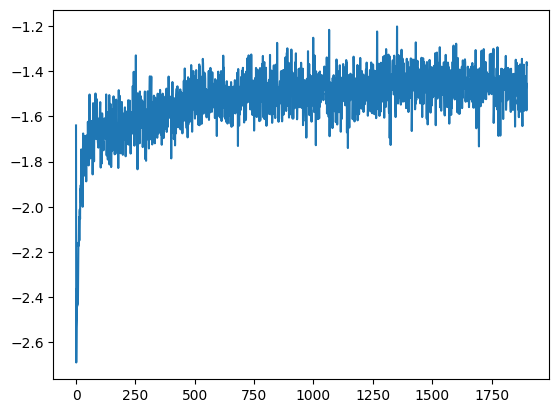

In [14]:
plt.plot(result)

In [ ]:
# test_architecture = AcesArchitectureEnv(52)
action = algorithm.compute_single_action(test_architecture.reset())
test_architecture.step(action)